In [1]:
### PYTHON IMPORTS
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle

C:\Users\Carl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
### LOAD ALL FILE PATHS TO ARRAY

cwd = os.getcwd()
dataPath = 'data'
pathToData = os.path.join(cwd, dataPath)

wordsToTrain = 'bed,cat,dog'
wordsToTrain_Array = wordsToTrain.split(',')

numberOfClasses = len(wordsToTrain_Array)

audioFiles = []
labelNames = []
classIndex = -1


# Find all folders inside the data folder
for classFile in os.listdir(pathToData):
    # For all folders found that match the wordsToTrain
    
    if(classFile in wordsToTrain_Array):
        classIndex += 1
        labelNames.append(classFile)
        # Check inside every folder
        pathToClass =  os.path.join(pathToData, classFile)
        # Loop through all files found
        for audioFile in os.listdir(pathToClass):
            # If the file format is an audio file
            if(audioFile.endswith('.wav')):
                # append the file path and the correct label to the audio files list
                audioFiles.append([os.path.join(pathToClass,audioFile),classIndex])
shuffle(audioFiles)
                
                

In [3]:
# LOAD ALL DATA TO ARRAYS

import matplotlib.pyplot as plt
import librosa.display

## Cross validation array structure

# Note - nearly 1700 datapoints for each class. 
# If limit data is used, reduce the number of files by 80%
limitData = True

dataPoints = len(audioFiles)
if(limitData):
    dataPoints = int((dataPoints*0.2))

# Set size of training
trainingSize = int(0.65 * dataPoints)
# Set size of validation
validationSize = int(0.25 * dataPoints)
# Rest should then be the testing set
testingSize = int(dataPoints - (trainingSize + validationSize))

print("Number of datapoints are: ",dataPoints)
print("Training samples: ",trainingSize)
print("Validation samples: ",validationSize)
print("Testing samples: ", testingSize)
print("Sum of all sets is ",trainingSize+validationSize+testingSize)

# Streams - link holder
#https://blog.francoismaillet.com/epic-celebration/
#https://stackoverflow.com/questions/42625286/how-to-process-audio-stream-in-realtime

Number of datapoints are:  1038
Training samples:  674
Validation samples:  259
Testing samples:  105
Sum of all sets is  1038


In [4]:
def fileToSpectrogram(path, seconds=1):
    
    # TODO: Find a way to make all arrays matching dimensions by cutting part of their size
    y, sr = librosa.load(path)
    # Cut the audio to the first 1 seconds
    y = y[:seconds * sr] 
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
    return S    


def plotSpectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    spectrogramData = spectrogram['data']
    librosa.display.specshow(librosa.power_to_db(spectrogramData, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    
    plt.colorbar(format='%+2.0f dB')
    
    splitPath = spectrogram['filename'].split('\\')
    
    plt.title(spectrogram['labelName'] + "  -  " + splitPath[len(splitPath)-1])
    plt.tight_layout()
    plt.show()


def fileObjectToDataObject(fileObject):
    pathToSoundArray = fileToSpectrogram(fileObject[0])
    targetVector = np.zeros((1,numberOfClasses))[0]
    targetVector[fileObject[1]] = 1
    
    dataObject = {
        'filename' : fileObject[0],
        'data' : pathToSoundArray,
        'label' : targetVector,
        'labelName' : labelNames[fileObject[1]]
    }
    
    return dataObject

In [5]:
# CHANGE DATA TO ARRAY

trainingArray = []
validationArray = []
testingArrray = []

# Load training data   # trainingSize
for i in range(trainingSize):
    newObject = fileObjectToDataObject(audioFiles[i])
    trainingArray.append(newObject)
    
for i in range(validationSize):
    # Get the correct index
    startIndex = i + trainingSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])

    validationArray.append(newObject)

for i in range(testingSize):
    # Get the correct index
    startIndex = i + trainingSize + validationSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])
    testingArrray.append(newObject)


## TODO: Fix the input files, some arrays have a different shape on Y [128,41] vs [128,44] ???

#IMAGE_HEIGHT   = 128 
#IMAGE_WIDTH    = 
#IMAGE_CHANNELS = 1 


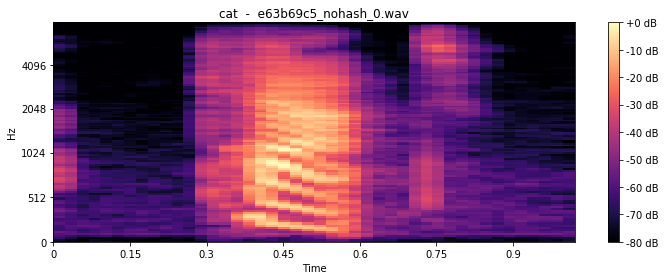

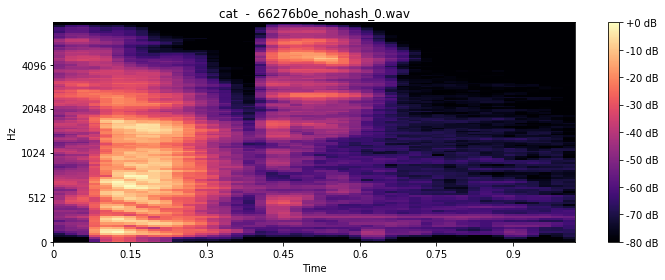

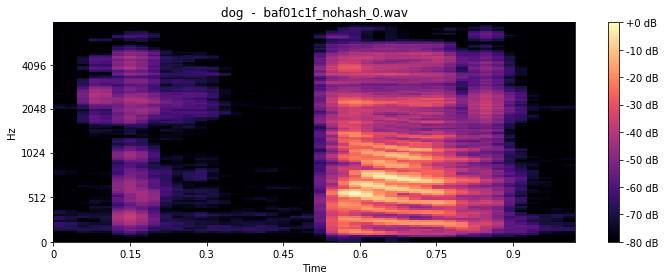

In [6]:
spectoToPrint = trainingArray[0]
plotSpectrogram(spectoToPrint)

spectoToPrint = trainingArray[500]
plotSpectrogram(spectoToPrint)
spectoToPrint = trainingArray[501]
plotSpectrogram(spectoToPrint)

44
index  0


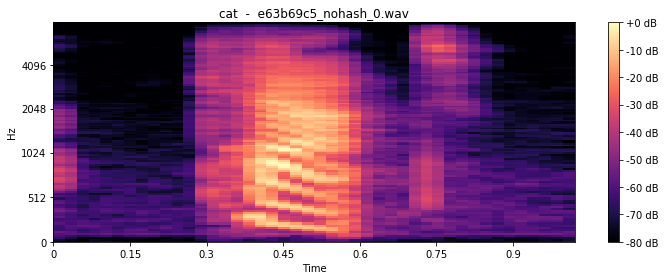

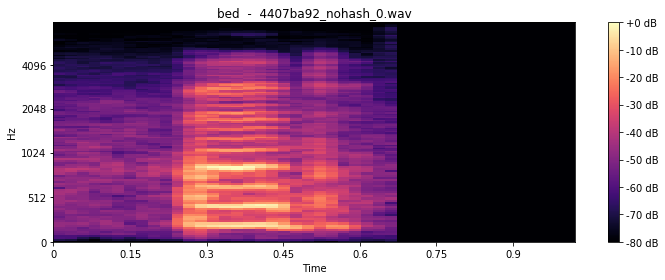

In [7]:
### NOTE 

"""
The code here below is the CNN structure that I used to my fruit project in the other course.
It doesn't work for this data since we need to restructure the data, layers, inputs and so on
I just put it here so you can see what the code looks like so we have a place to start :)


"""
maxLen = 0
minLen = 1000

maxindex = 0
minindex = 0
for i in range(len(trainingArray)):
    maxOfData = np.shape(trainingArray[i]['data'])[1]
    if(maxOfData > maxLen):
        maxLen = maxOfData
        maxindex = i
    if(maxOfData < minLen):
        minLen = maxOfData
        minindex = i

print(maxLen)
print("index ", maxindex)
spectoToPrint = trainingArray[maxindex]
plotSpectrogram(spectoToPrint)


for i in range(len(trainingArray)):
    if(np.shape(trainingArray[i]['data'])[1] < maxLen):
        diff = maxLen - np.shape(trainingArray[i]['data'])[1]
        emptyArray = np.zeros([128,diff])
        
        a = np.hstack((trainingArray[i]['data'],emptyArray))
        trainingArray[i]['data'] = a
        #if(i == minindex):
            #plotSpectrogram(spectoToPrint(trainingArray[i]))

spectoToPrint = trainingArray[minindex]
plotSpectrogram(spectoToPrint)        


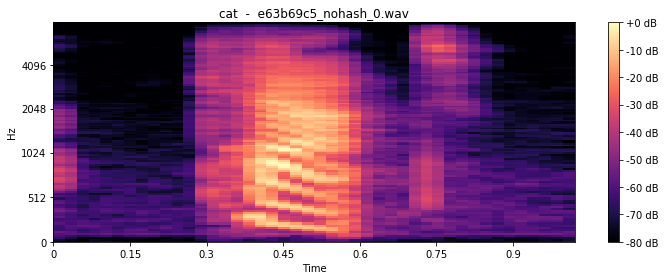

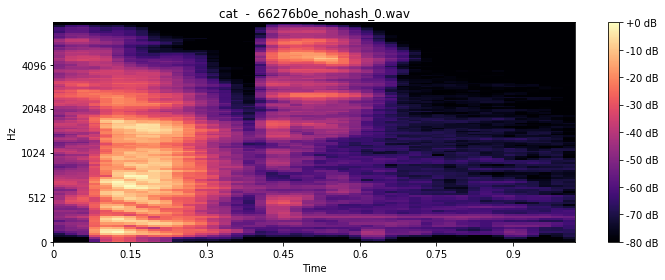

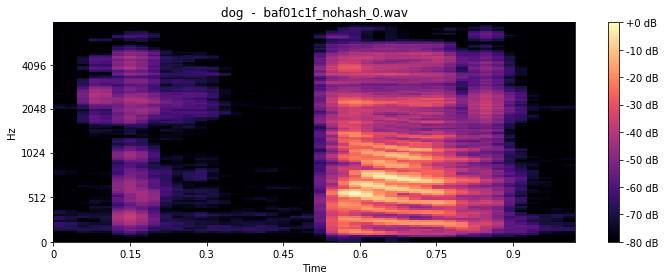

In [8]:
spectoToPrint = trainingArray[0]
plotSpectrogram(spectoToPrint)

spectoToPrint = trainingArray[500]
plotSpectrogram(spectoToPrint)
spectoToPrint = trainingArray[501]
plotSpectrogram(spectoToPrint)

In [9]:
# create some wrappers for simplicity
def conv2d(inputData,weights,bias,strides=1):
    # conv2d wrapper, with bias and relu activation
    inputData = tf.nn.conv2d(inputData,weights,strides=[1,strides,strides,1],padding='SAME')
    inputData = tf.nn.bias_add(inputData,bias)
    return tf.nn.relu(inputData)

def maxpool2d(inputData,k=2):
    # max2d wrapper
    return tf.nn.max_pool(inputData,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')

def conv_net(inputData,weights,biases,dropout):
    inputData = tf.reshape(inputData, shape=[-1,128,maxLen,1])
    print("a")
    # convolustion layer
    conv1 = conv2d(inputData,weights['wc1'],biases['bc1'])
    # max pooling
    print("b")

    conv1 = maxpool2d(conv1, k=2)
    print("c")

    # convolustion layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    print("d")

    # max pooling 
    conv2 = maxpool2d(conv2, k=2)
    print("a")
    
    # convolustion layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # max pooling 
    conv3 = maxpool2d(conv3, k=2)
    
    # convolustion layer
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    # max pooling
    conv4 = maxpool2d(conv4, k=2)
    
    # convolustion layer
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # max pooling 
    conv5 = maxpool2d(conv5, k=2)
    
    # apply dropout
    conv5 = tf.nn.dropout(conv5, 0.9)

    # fully connected layer
    fc1 = tf.reshape(conv5, shape=[-1,weights['wd1'].get_shape().as_list()[0]])
    # print('conv4 shape:', conv4.shape, ', fc1 shape:', fc1.shape)
    fc1 = tf.add(tf.matmul(fc1,weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # apply dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # output, class prediction
    out = tf.add(tf.matmul(fc1,weights['out']), biases['out'])
    # apply softmax in the end
    prediction = tf.nn.softmax(out)
    return prediction

In [10]:
# parameters

lr_start = 0.001
lr_end = 0.0001
learning_rate = lr_start

num_steps = 5000
batch_size = 64
update_step = 5
display_step = 100
num_classes = numberOfClasses

num_input = 128*44*1
dropout = 0.5

# saver train parameters
useCkpt = True
checkpoint_step = 5
checkpoint_dir = os.getcwd()+'\\checkpoint\\'

In [11]:
# store layers weighta and bias
weights = {
    # 5x5 conv, 3 inputs, 16 outpus
    'wc1': tf.get_variable('wc1',[3,3,1,32],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 16 input, 32 outpus
    'wc2': tf.get_variable('wc2',[3,3,32,64],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc3': tf.get_variable('wc3',[3,3,64,128],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 64 inputs, 128 outputs
    'wc4': tf.get_variable('wc4',[3,3,128,256],initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 128 inputs, 256 outputs
    'wc5': tf.get_variable('wc5', [3, 3, 256, 512], initializer=tf.contrib.layers.xavier_initializer_conv2d()),

    # fully connected, 7*7*128 inputs, 2048 outputs
    'wd1': tf.get_variable('wd1',[1*1*512,2048],initializer=tf.contrib.layers.xavier_initializer()),
    # 32 inputs, 26 outputs (class prediction)
    'out': tf.get_variable('fc1',[2048,num_classes],initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'bc3': tf.Variable(tf.zeros([128])),
    'bc4': tf.Variable(tf.zeros([256])),
    'bc5': tf.Variable(tf.zeros([512])),
    'bd1': tf.Variable(tf.zeros([2048])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

Instructions for updating:
Use the retry module or similar alternatives.


In [24]:
# tf graph input
X = tf.placeholder(tf.float32,[None,num_input])
Y = tf.placeholder(tf.float32,[None,num_classes])
keep_prob = tf.placeholder(tf.float32)

# model construct
logits = conv_net(X,weights,biases,keep_prob)
# last layer
prediction = logits

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                                 labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss=loss_op)

# evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

# initialization
init = tf.global_variables_initializer()


def trainModel(data, targetVector):
    
    for epoch in range(1, num_steps + 1):
        with tf.Graph().as_default():
            
            
            
            batch_x = data
            batch_y = targetVector
            batch_x = np.reshape(batch_x, [1, num_input])
            batch_y = np.transpose(targetVector)

            # run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
           

            if epoch % update_step == 0 or epoch == 1:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 1})
                
                # weight decay
                learning_rate = updateLearningRate(acc, lr_start=lr_start)
                if train_acc_target <= acc:
                    acc_meet_target_cnt += 1
                else:
                    acc_meet_target_cnt = 0
                
            if epoch % display_step == 0 or epoch == 1:
                print( "epoch " + str(epoch) + ", minibatch loss = " + \
                      "{:.4f}".format(loss) + ", training accuracy = " + \
                      "{:.4f}".format(acc) , ", acc_meet_target_cnt = " + "{:.4f}".format(acc_meet_target_cnt))

            if useCkpt:
                if step % checkpoint_step == 0:
                    saver.save(sess, checkpoint_dir + 'model' + +'.ckpt')

def updateLearningRate(acc,lr_start):
    learning_rate_new = lr_start - acc*lr_start*0.9
    return learning_rate_new

saver = tf.train.Saver()

In [14]:
print(trainingArray[0]['data'])
print(trainingArray[0]['label'])

[[1.44909821e-06 3.85386576e-07 2.38557254e-07 ... 3.59187138e-06
  4.00801028e-06 7.89162193e-06]
 [5.01731758e-06 1.70521201e-06 9.68061580e-07 ... 3.36190357e-06
  1.98874456e-06 4.56850312e-06]
 [2.24411189e-05 6.82046163e-06 1.44299523e-06 ... 4.41854492e-06
  4.34718258e-06 5.15235183e-06]
 ...
 [2.61984404e-08 2.04175386e-08 2.38976728e-08 ... 9.39066446e-09
  3.06733196e-08 1.10026895e-07]
 [8.62180819e-09 5.33293098e-09 3.45417705e-09 ... 1.81131117e-09
  4.23829626e-09 9.30036004e-09]
 [2.61999935e-09 7.90003402e-10 1.31130467e-10 ... 1.56451154e-10
  5.41542257e-10 2.05224299e-09]]
[0. 1. 0.]


In [25]:

# TRAINING LOOP
with tf.Session() as sess:
    # run the initailizer
    sess.run(init)

    # train batch
    tfrecords_name = 'fruits_train.tfrecords'
    images, labels = trainingArray[0]['data'], trainingArray[0]['label'] #inputs(tfrecords_name, batch_size, shuffle = True)
    # create coord
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    """
    if useCkpt:
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            pass
    """
    # train the model
    trainModel(images, labels)
    print("Optimization finish!")

    # close coord
    coord.request_stop()
    coord.join(threads)
    sess.close()

ValueError: Cannot feed value of shape (3,) for Tensor 'Placeholder_16:0', which has shape '(?, 3)'